In [2]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import glob
import random
from PIL import Image


In [3]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset


In [4]:
dframe = pd.read_csv(
    "D:\Lab on python\Lab_1_var_4\Lab2\csv_files\datasets.csv", delimiter=",", names=["Absolute path", "Relative path", "Class"]
)
img_list=dframe["Absolute path"].tolist()
random.shuffle(img_list)
print(img_list[:5])


['D:\\Lab on python\\Lab_1_var_4\\dataset\\rose\\0467.jpg', 'D:\\Lab on python\\Lab_1_var_4\\dataset\\tulip\\0180.jpg', 'D:\\Lab on python\\Lab_1_var_4\\dataset\\tulip\\0797.jpg', 'D:\\Lab on python\\Lab_1_var_4\\dataset\\rose\\0527.jpg', 'D:\\Lab on python\\Lab_1_var_4\\dataset\\rose\\0808.jpg']


In [5]:
img_label=[]
for i in range(len(img_list)):
    img_label.append(os.path.basename(os.path.dirname(img_list[i])))
print(img_label[:5])

['rose', 'tulip', 'tulip', 'rose', 'rose']


In [6]:
train_list = img_list[0 : int(len(img_list) * 0.8)]
test_list = img_list[int(len(img_list) * 0.8) : int(len(img_list) * 0.9)]
val_list = img_list[int(len(img_list) * 0.9) : int(len(img_list))]
print(len(train_list ))
print(len(test_list))
print(len(val_list))



1608
201
202


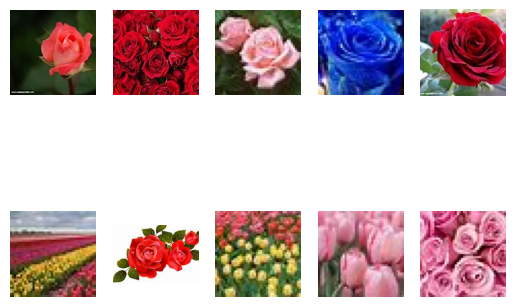

In [7]:
random_idx = np.random.randint(1,len(img_list),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(img_list[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')


plt.show()

In [12]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_label[idx]
        if label == 'rose':
            label=0
        elif label == 'tulip':
            label=1
        return img_transformed,label  

In [13]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

test_transforms = transforms.Compose([   
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
    
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size=100, 
                                           shuffle=True )

test_loader = torch.utils.data.DataLoader(dataset = test_data, 
                                          batch_size=100, 
                                          shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                         batch_size=100, 
                                         shuffle=False)

In [15]:
print(len(train_data), len(train_loader))
train_data[0][0].shape


1608 17


torch.Size([3, 224, 224])

In [16]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = Cnn()
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [19]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [20]:
epochs = 20
accuracy_values = []
loss_values = []
val_accuracy_values=[]
val_loss_values=[]
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    accuracy_values.append(epoch_accuracy.item())
    loss_values.append(epoch_loss.item())

    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
              
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
        val_accuracy_values.append(epoch_val_accuracy.item())
        val_loss_values.append(epoch_val_loss.item()) 

Epoch : 1, train accuracy : 0.7123528718948364, train loss : 0.554721474647522
Epoch : 1, val_accuracy : 0.65666663646698, val_loss : 0.8028221130371094
Epoch : 2, train accuracy : 0.8467648029327393, train loss : 0.38119903206825256
Epoch : 2, val_accuracy : 0.6666666269302368, val_loss : 0.9976449608802795
Epoch : 3, train accuracy : 0.8773529529571533, train loss : 0.30694928765296936
Epoch : 3, val_accuracy : 0.653333306312561, val_loss : 1.058734655380249
Epoch : 4, train accuracy : 0.8829411864280701, train loss : 0.2781728506088257
Epoch : 4, val_accuracy : 0.48000001907348633, val_loss : 1.204825758934021
Epoch : 5, train accuracy : 0.9055883288383484, train loss : 0.2315274178981781
Epoch : 5, val_accuracy : 0.6399999856948853, val_loss : 1.2636830806732178
Epoch : 6, train accuracy : 0.9205881953239441, train loss : 0.19859229028224945
Epoch : 6, val_accuracy : 0.6633332967758179, val_loss : 1.2908709049224854
Epoch : 7, train accuracy : 0.9282352924346924, train loss : 0.189

In [21]:
def show_results(acc, loss):
    plt.figure(figsize=(15, 5))
    plt.plot(range(20), acc, color="green")
    plt.legend(["Accuracy"])
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(range(20), loss, color="blue")
    plt.legend(["Loss"])
    plt.show() 
    
    print(acc, '\n',loss)

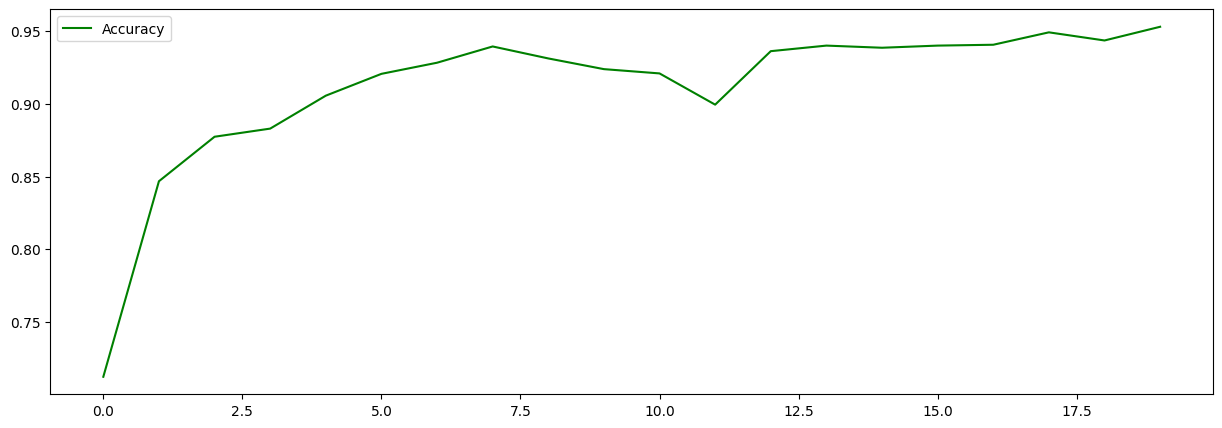

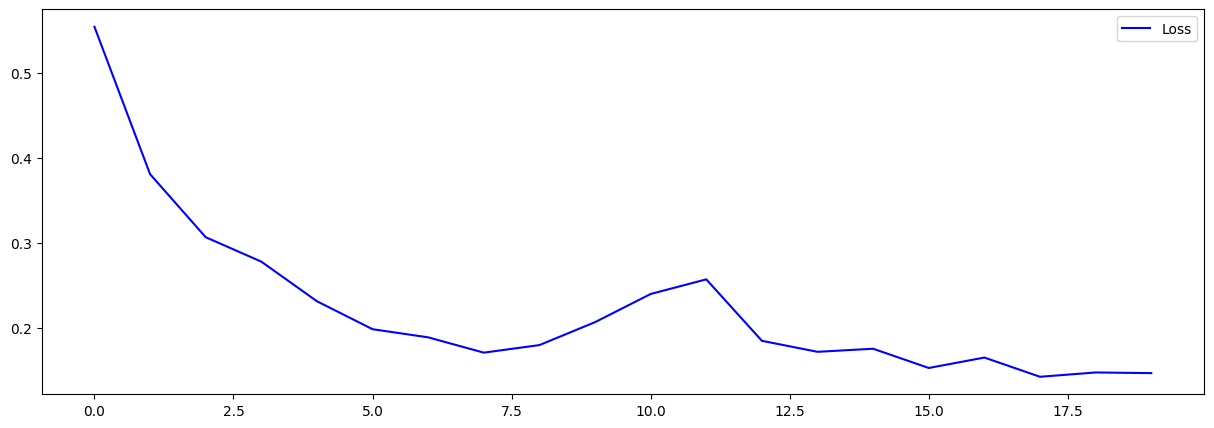

[0.7123528718948364, 0.8467648029327393, 0.8773529529571533, 0.8829411864280701, 0.9055883288383484, 0.9205881953239441, 0.9282352924346924, 0.9394116401672363, 0.9311763644218445, 0.9238234758377075, 0.9208822846412659, 0.8994116187095642, 0.9361763596534729, 0.9399998784065247, 0.9385293126106262, 0.9399998784065247, 0.9405881762504578, 0.9491176009178162, 0.9435293078422546, 0.9529410600662231] 
 [0.554721474647522, 0.38119903206825256, 0.30694928765296936, 0.2781728506088257, 0.2315274178981781, 0.19859229028224945, 0.18902429938316345, 0.17100299894809723, 0.17990386486053467, 0.20689132809638977, 0.24008533358573914, 0.2573068141937256, 0.18493065237998962, 0.1719878911972046, 0.17560093104839325, 0.15294888615608215, 0.1652202159166336, 0.1425868719816208, 0.14766916632652283, 0.14688555896282196]


In [22]:
show_results(accuracy_values, loss_values)

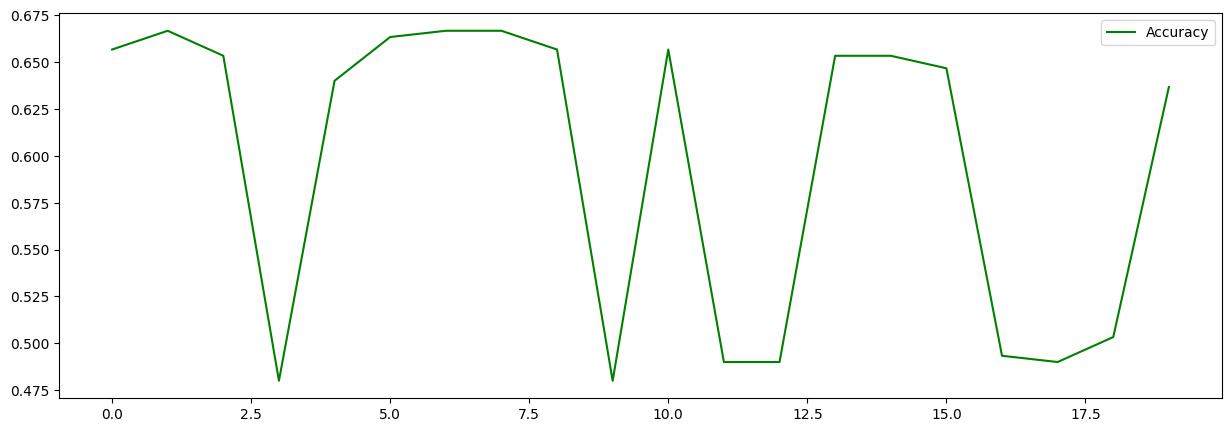

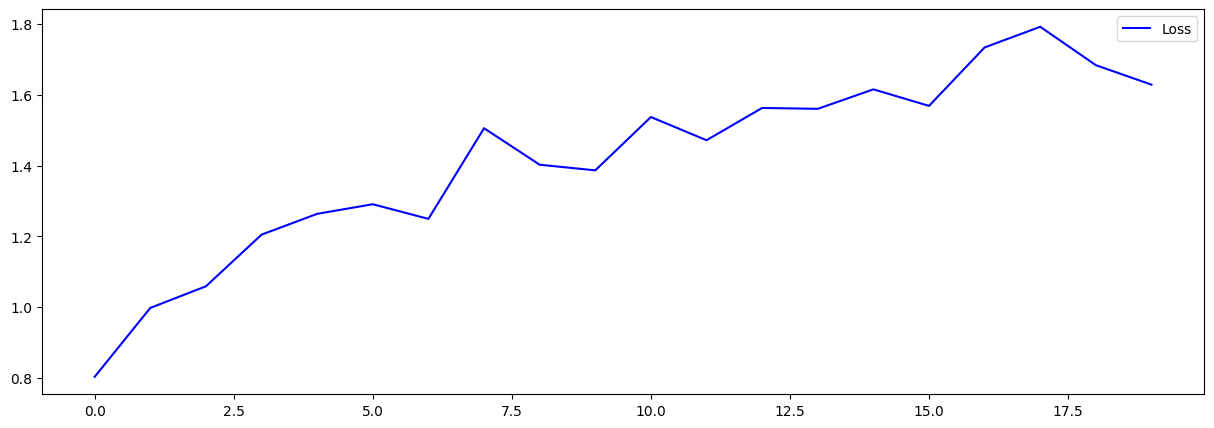

[0.65666663646698, 0.6666666269302368, 0.653333306312561, 0.48000001907348633, 0.6399999856948853, 0.6633332967758179, 0.6666666269302368, 0.6666666269302368, 0.65666663646698, 0.48000001907348633, 0.65666663646698, 0.49000000953674316, 0.49000000953674316, 0.653333306312561, 0.653333306312561, 0.6466666460037231, 0.4933333396911621, 0.49000000953674316, 0.503333330154419, 0.6366666555404663] 
 [0.8028221130371094, 0.9976449608802795, 1.058734655380249, 1.204825758934021, 1.2636830806732178, 1.2908709049224854, 1.2494478225708008, 1.505842924118042, 1.4026157855987549, 1.386725902557373, 1.537503719329834, 1.4719165563583374, 1.563209056854248, 1.5607032775878906, 1.6158020496368408, 1.5690864324569702, 1.7343999147415161, 1.792802333831787, 1.6841683387756348, 1.6290664672851562]


In [23]:
show_results(val_accuracy_values, val_loss_values)

In [24]:
rose_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        rose_probs += list(zip(list(fileid), preds_list))
rose_probs.sort(key = lambda x : int(x[0]))
rose_probs[:10]

[(tensor(0), 0.017033983021974564),
 (tensor(0), 0.001871361630037427),
 (tensor(0), 0.0016797864809632301),
 (tensor(0), 0.9039789438247681),
 (tensor(0), 0.9930003881454468),
 (tensor(0), 0.6610128283500671),
 (tensor(0), 0.0008954364457167685),
 (tensor(0), 0.9734480977058411),
 (tensor(0), 0.978617787361145),
 (tensor(0), 0.23816920816898346)]

In [25]:
idx = list(i for i in range(len(rose_probs)))
prob = list(map(lambda x: x[1],rose_probs))

In [26]:
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('result.csv',index=False)
submission

,id,label
0,0,0.017034
1,1,0.001871
2,2,0.001680
3,3,0.903979
4,4,0.993000
...,...,...
196,196,0.005720
197,197,0.012321
198,198,0.992443
199,199,0.966252


In [27]:
torch.save(model.state_dict(), os.path.join("D:\Lab on python\Lab_1_var_4\Lab5", "weight.pt"))

In [30]:
mymodel = Cnn()
model = Cnn().to(device)
mymodel.load_state_dict(torch.load(os.path.join("D:\Lab on python\Lab_1_var_4\Lab5", "weight.pt")))

<All keys matched successfully>

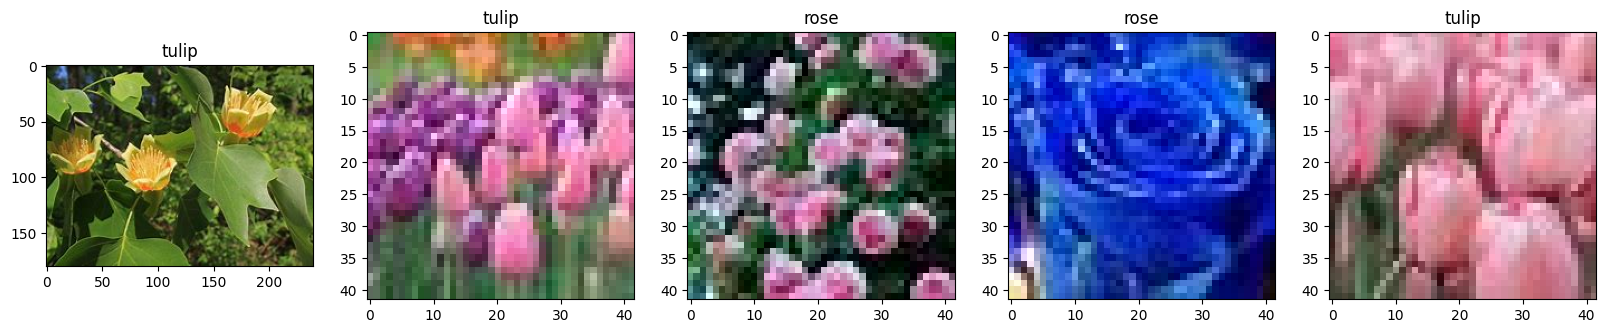

In [63]:
id_list = []
class_ = {0: 'rose', 1: 'tulip'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = train_list[i]
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)